# Libraries

In [31]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge, Lasso
from xgboost import XGBRegressor
!pip install catboost
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from joblib import dump
import matplotlib.dates as mdates
import statsmodels.api as sm

# Global Plot Syling


In [32]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Dataset Loading

In [5]:
def load_dataset_file(path):

    print("Reading file...")
    df = pd.read_csv(
        path, sep=';', low_memory=False,
        na_values=['?', 'nan', ''], on_bad_lines='skip'
    )

    print("Parsing datetime...")
    df['dt'] = pd.to_datetime(df['Date'] + ' ' + df['Time'],format='%d/%m/%Y %H:%M:%S', errors='coerce')
    df.drop(['Date', 'Time'], axis=1, inplace=True)
    df = df[~df['dt'].isna()].copy()
    df.set_index('dt', inplace=True)

    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

    df.sort_index(inplace=True)
    print("Loaded from file:", df.shape)
    return df

DATA_PATH = 'household_power_consumption.txt'
df = load_dataset_file(DATA_PATH)

Reading file...
Parsing datetime...
Loaded from file: (162495, 7)


In [6]:
print(f"\n📊 Dataset: {len(df):,} records from {df.index.min()} to {df.index.max()}")



📊 Dataset: 162,495 records from 2006-12-16 17:24:00 to 2007-04-08 13:38:00


# EDA


1️⃣ Dataset Overview:
Total Records: 162,495
Date Range: 2006-12-16 to 2007-04-08
Duration: 112 days
Features: 7

2️⃣ Column Information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 162495 entries, 2006-12-16 17:24:00 to 2007-04-08 13:38:00
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Global_active_power    162486 non-null  float64
 1   Global_reactive_power  162485 non-null  float64
 2   Voltage                162485 non-null  float64
 3   Global_intensity       162485 non-null  float64
 4   Sub_metering_1         162485 non-null  float64
 5   Sub_metering_2         162485 non-null  float64
 6   Sub_metering_3         162485 non-null  float64
dtypes: float64(7)
memory usage: 9.9 MB
None

3️⃣ Statistical Summary:
       Global_active_power  Global_reactive_power     Voltage  \
count           162486.000             162485.000  162485.000   
mean                 1.483             

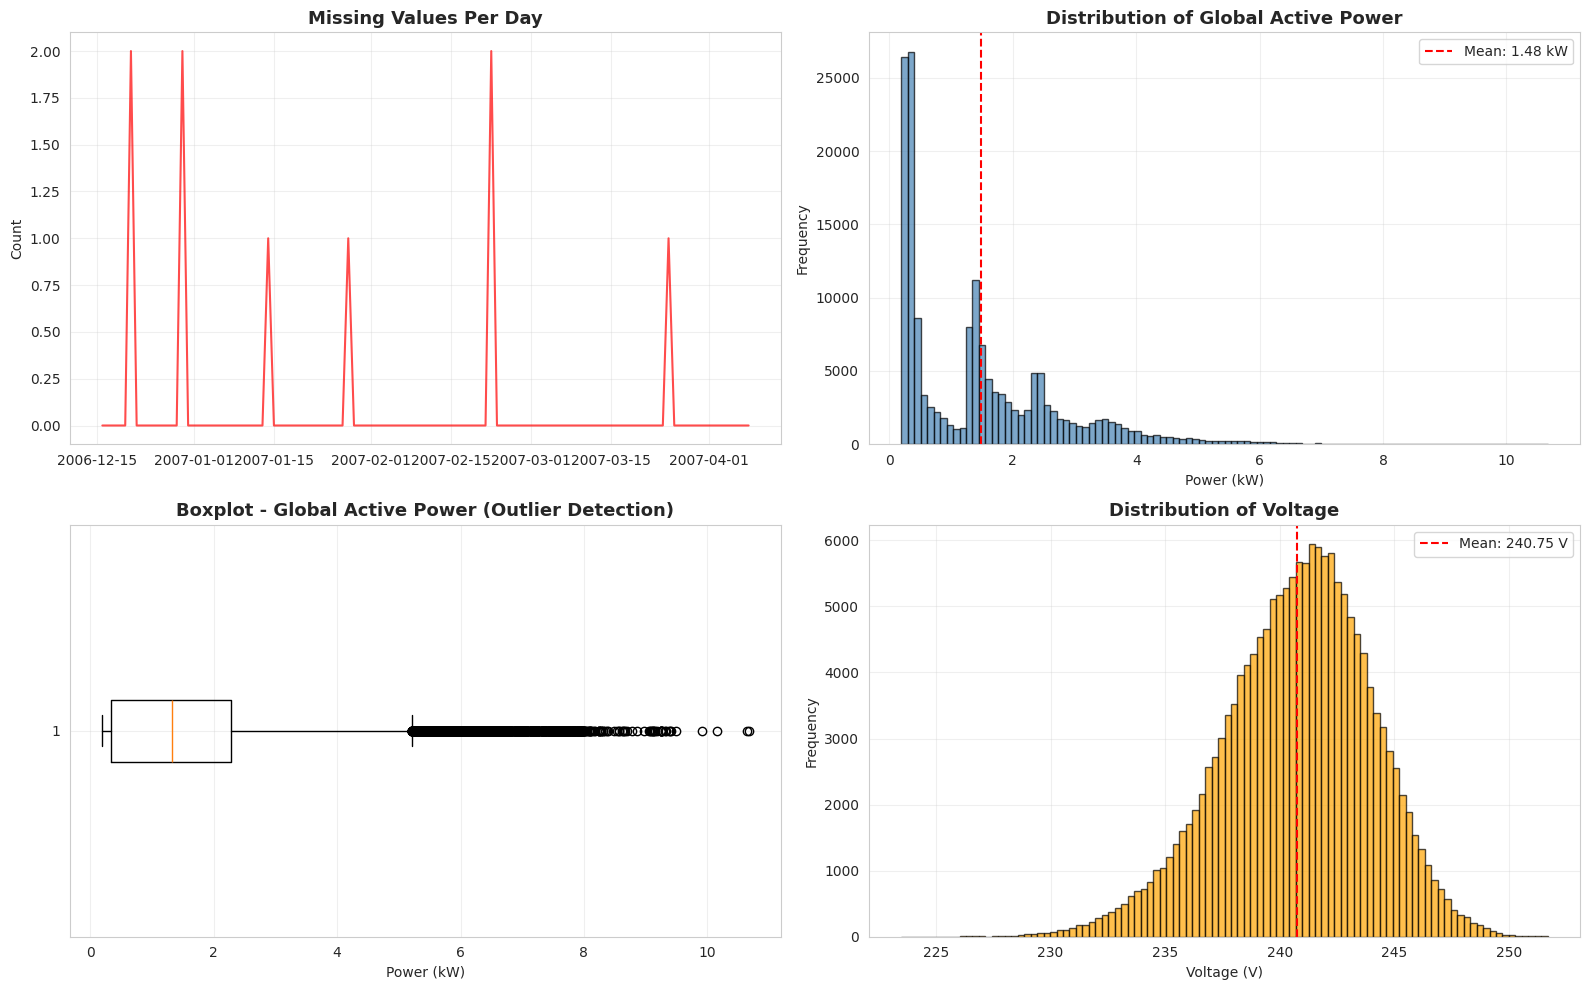

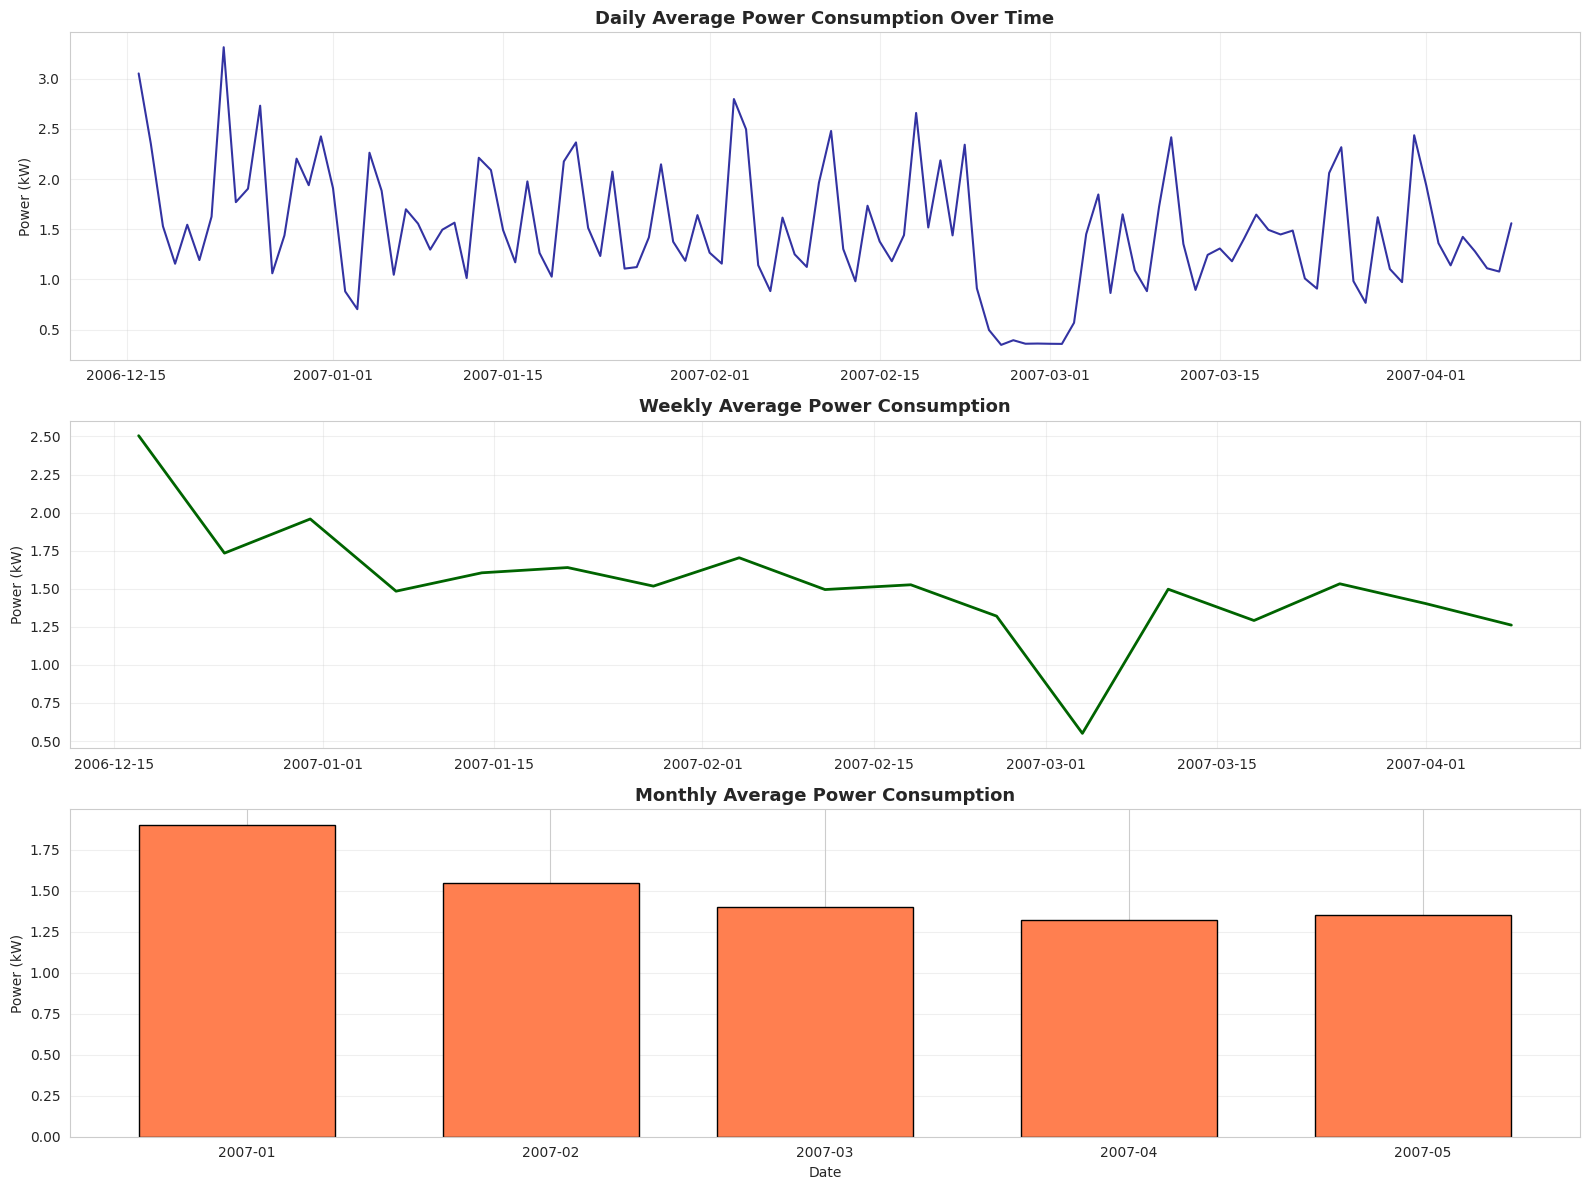


6️⃣ Correlation Analysis:


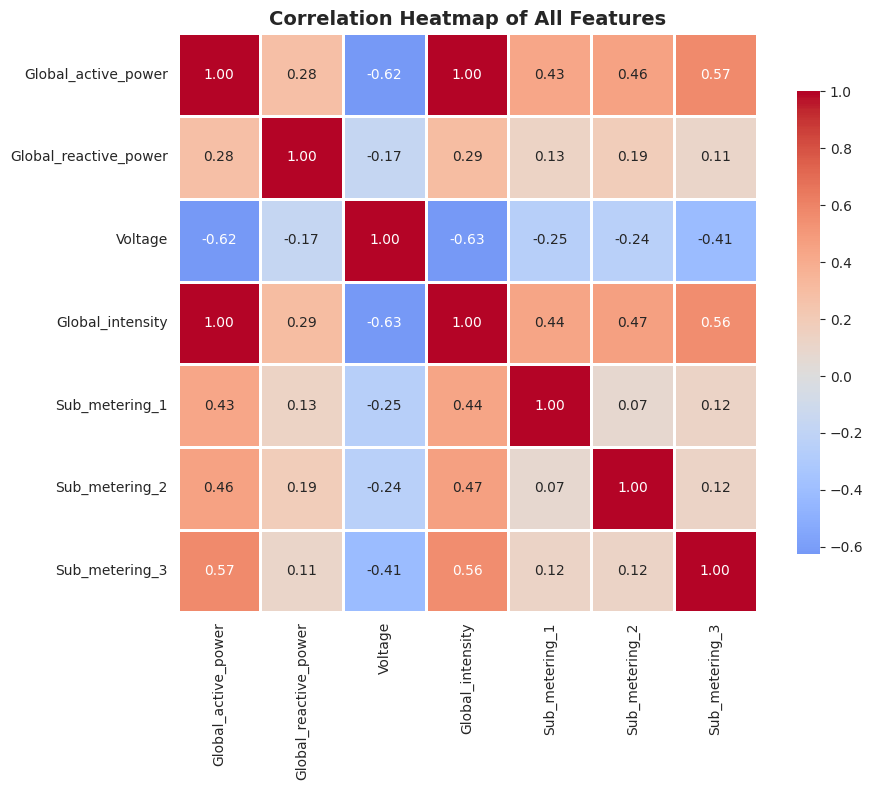


7️⃣ Top Correlations with Global_active_power:
Global_active_power      1.000000
Global_intensity         0.999102
Voltage                  0.620798
Sub_metering_3           0.568480
Sub_metering_2           0.459896
Sub_metering_1           0.431773
Global_reactive_power    0.283120
Name: Global_active_power, dtype: float64


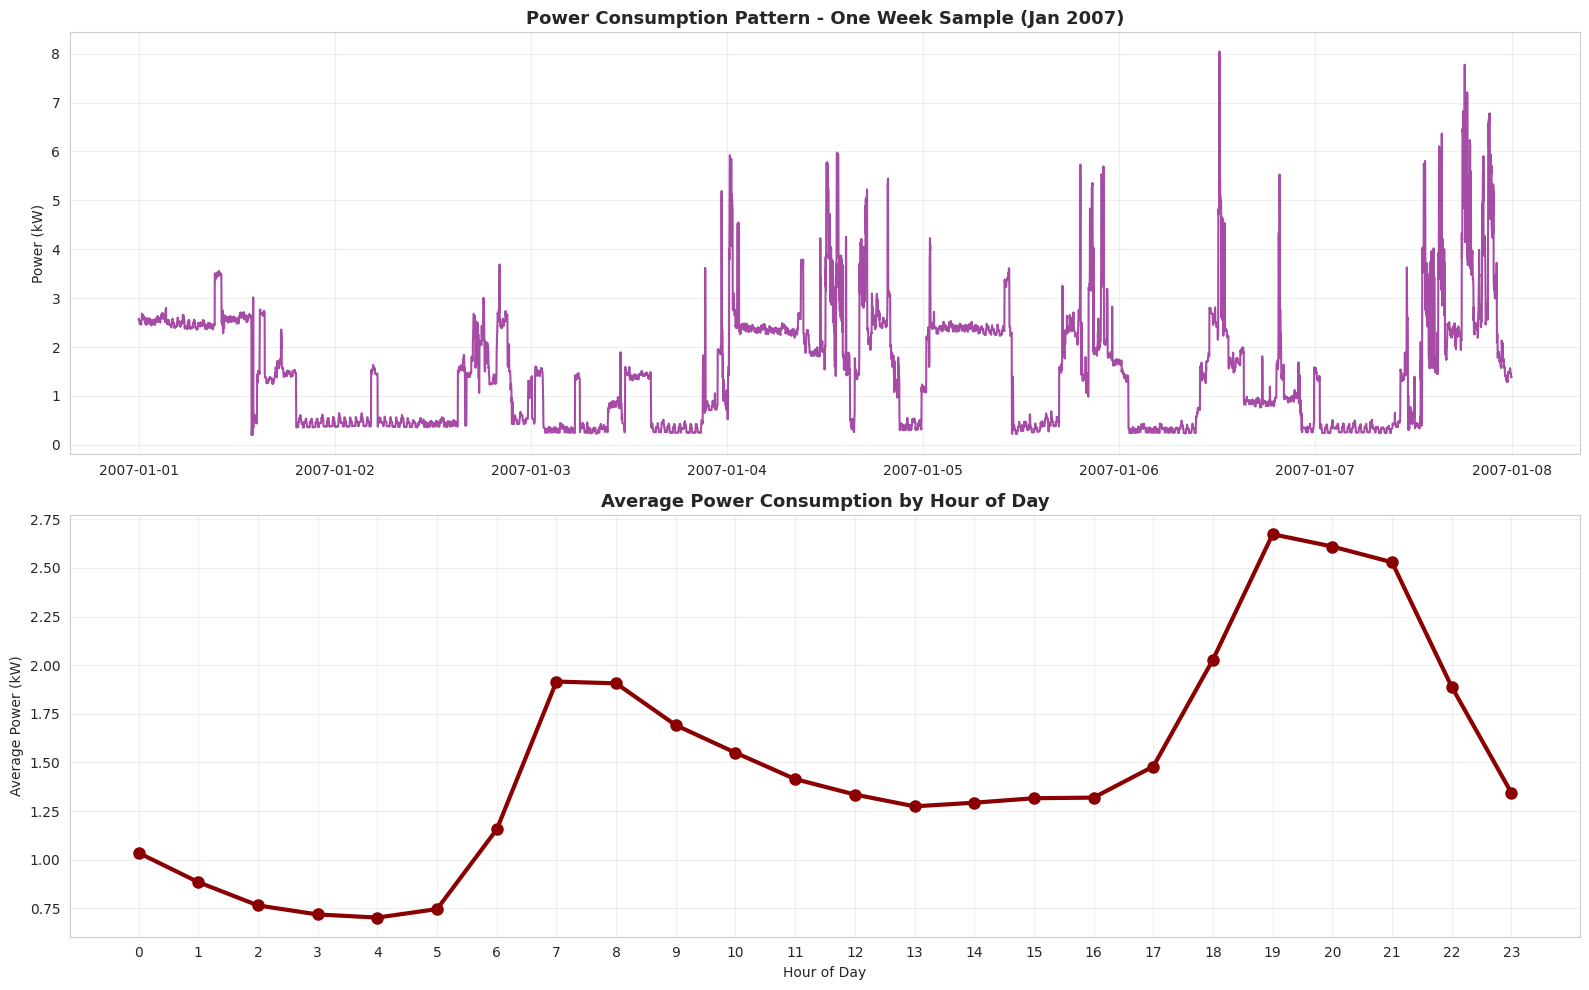

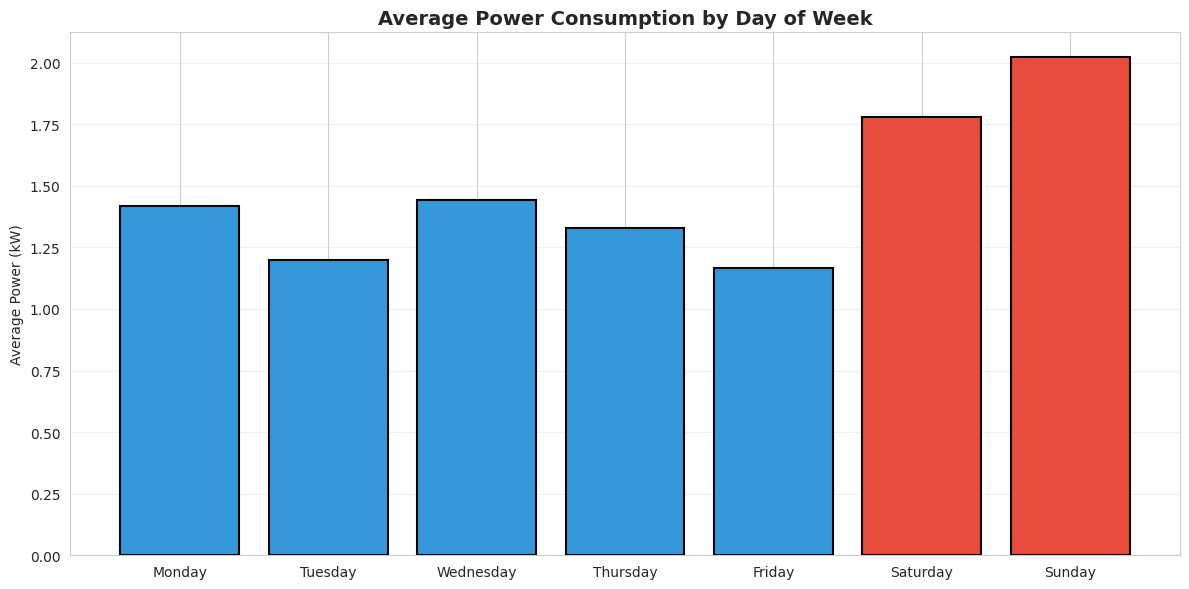

In [7]:
# Basic Information

print("\n1️⃣ Dataset Overview:")
print(f"Total Records: {len(df):,}")
print(f"Date Range: {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}")
print(f"Duration: {(df.index.max() - df.index.min()).days} days")
print(f"Features: {df.shape[1]}")

print("\n2️⃣ Column Information:")
print(df.info())

print("\n3️⃣ Statistical Summary:")
print(df.describe().round(3))

print("\n4️⃣ Missing Values:")
missing = df.isna().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({'Missing': missing, 'Percentage': missing_pct})
print(missing_df[missing_df['Missing'] > 0])

print("\n5️⃣ Creating EDA -> ")

#Missing Values Pattern
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Missing values over time
missing_daily = df['Global_active_power'].isna().resample('D').sum()
axes[0, 0].plot(missing_daily.index, missing_daily.values, color='red', alpha=0.7)
axes[0, 0].set_title('Missing Values Per Day', fontsize=13, fontweight='bold')
axes[0, 0].set_ylabel('Count')
axes[0, 0].grid(True, alpha=0.3)

# Distribution of Global Active Power
axes[0, 1].hist(df['Global_active_power'].dropna(), bins=100, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 1].set_title('Distribution of Global Active Power', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Power (kW)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(df['Global_active_power'].mean(), color='red', linestyle='--',
                    label=f"Mean: {df['Global_active_power'].mean():.2f} kW")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Boxplot for outlier detection
axes[1, 0].boxplot(df['Global_active_power'].dropna(), vert=False)
axes[1, 0].set_title('Boxplot - Global Active Power (Outlier Detection)', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Power (kW)')
axes[1, 0].grid(True, alpha=0.3)

# Voltage distribution
axes[1, 1].hist(df['Voltage'].dropna(), bins=100, edgecolor='black', alpha=0.7, color='orange')
axes[1, 1].set_title('Distribution of Voltage', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Voltage (V)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(df['Voltage'].mean(), color='red', linestyle='--',
                    label=f"Mean: {df['Voltage'].mean():.2f} V")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('eda_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Daily average power
daily_avg = df['Global_active_power'].resample('D').mean()
axes[0].plot(daily_avg.index, daily_avg.values, color='darkblue', alpha=0.8)
axes[0].set_title('Daily Average Power Consumption Over Time', fontsize=13, fontweight='bold')
axes[0].set_ylabel('Power (kW)')
axes[0].grid(True, alpha=0.3)

# Weekly pattern
weekly_avg = df['Global_active_power'].resample('W').mean()
axes[1].plot(weekly_avg.index, weekly_avg.values, color='darkgreen', linewidth=2)
axes[1].set_title('Weekly Average Power Consumption', fontsize=13, fontweight='bold')
axes[1].set_ylabel('Power (kW)')
axes[1].grid(True, alpha=0.3)

# Monthly pattern
monthly_avg = df['Global_active_power'].resample('M').mean()
axes[2].bar(monthly_avg.index, monthly_avg.values, width=20, color='coral', edgecolor='black')
axes[2].set_title('Monthly Average Power Consumption', fontsize=13, fontweight='bold')
axes[2].set_ylabel('Power (kW)')
axes[2].set_xlabel('Date')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('eda_time_series.png', dpi=300, bbox_inches='tight')
plt.show()

# Correlation Analysis
print("\n6️⃣ Correlation Analysis:")
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap of All Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('eda_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

# Top correlations with target
print("\n7️⃣ Top Correlations with Global_active_power:")
target_corr = corr_matrix['Global_active_power'].abs().sort_values(ascending=False)
print(target_corr.head(7))

# Hourly and Daily Patterns
sample_week = df['2007-01-01':'2007-01-07']
if len(sample_week) > 0:
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))

    # Hourly pattern (one week sample)
    axes[0].plot(sample_week.index, sample_week['Global_active_power'],
                 color='purple', alpha=0.7, linewidth=1.5)
    axes[0].set_title('Power Consumption Pattern - One Week Sample (Jan 2007)',
                      fontsize=13, fontweight='bold')
    axes[0].set_ylabel('Power (kW)')
    axes[0].grid(True, alpha=0.3)

    # Average hourly pattern
    hourly_pattern = df.groupby(df.index.hour)['Global_active_power'].mean()
    axes[1].plot(hourly_pattern.index, hourly_pattern.values, marker='o',
                 linewidth=3, markersize=8, color='darkred')
    axes[1].set_title('Average Power Consumption by Hour of Day', fontsize=13, fontweight='bold')
    axes[1].set_xlabel('Hour of Day')
    axes[1].set_ylabel('Average Power (kW)')
    axes[1].set_xticks(range(0, 24))
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('eda_patterns.png', dpi=300, bbox_inches='tight')
    plt.show()

# Figure 5: Day of Week Pattern
weekly_pattern = df.groupby(df.index.dayofweek)['Global_active_power'].mean()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(12, 6))
plt.bar(days, weekly_pattern.values, color=['#3498db']*5 + ['#e74c3c']*2,
        edgecolor='black', linewidth=1.5)
plt.title('Average Power Consumption by Day of Week', fontsize=14, fontweight='bold')
plt.ylabel('Average Power (kW)')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('eda_weekly_pattern.png', dpi=300, bbox_inches='tight')
plt.show()


# Data Cleaning

In [8]:
def clean_data(df):
    print("\nCleaning data...")
    print(f"Missing values before: {df.isna().sum().sum():,}")

    # Remove extreme outliers (IQR method)
    for col in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[col].quantile(0.01)
        Q3 = df[col].quantile(0.99)
        IQR = Q3 - Q1
        lower = Q1 - 3 * IQR
        upper = Q3 + 3 * IQR
        df.loc[(df[col] < lower) | (df[col] > upper), col] = np.nan

    # Interpolate with time-based method
    df = df.interpolate(method='time', limit_direction='both', limit=30)
    df = df.fillna(method='ffill', limit=60).fillna(method='bfill', limit=60)

    print(f"Missing values after: {df.isna().sum().sum():,}")
    return df

df = clean_data(df)


Cleaning data...
Missing values before: 69
Missing values after: 0


# Resampling on hourly basis

In [9]:
def resample_hourly(df):

    print("\nResampling to hourly...")

    hourly = df.resample('H').agg({
        'Global_active_power': 'mean',
        'Global_reactive_power': 'mean',
        'Voltage': 'mean',
        'Global_intensity': 'mean',
        'Sub_metering_1': 'sum',
        'Sub_metering_2': 'sum',
        'Sub_metering_3': 'sum'
    })

    counts = df['Global_active_power'].resample('H').count()
    valid_hours = counts[counts >= 30].index
    hourly = hourly[hourly.index.isin(valid_hours)]

    for i in [1, 2, 3]:
        hourly[f'Sub_metering_{i}'] = hourly[f'Sub_metering_{i}'] / 1000

    print(f"Hourly data: {len(hourly):,} hours")
    return hourly

hourly = resample_hourly(df)


Resampling to hourly...
Hourly data: 2,709 hours


# Feature Engineering

In [10]:
def create_features(hourly, target_col='Global_active_power'):

    print("\nEngineering features...")

    df_feat = pd.DataFrame({'y': hourly[target_col]})

    # Lags
    lags = [1, 2, 3, 6, 12, 24, 48, 72, 168, 336]
    for lag in lags:
        df_feat[f'lag_{lag}h'] = df_feat['y'].shift(lag)

    # Rolling statistics
    windows = [3, 6, 12, 24, 48, 168]
    for w in windows:
        roll = df_feat['y'].shift(1).rolling(window=w)
        df_feat[f'roll_mean_{w}h'] = roll.mean()
        df_feat[f'roll_std_{w}h'] = roll.std()
        df_feat[f'roll_min_{w}h'] = roll.min()
        df_feat[f'roll_max_{w}h'] = roll.max()

    # Exponential weighted
    for span in [12, 24, 48]:
        df_feat[f'ewm_{span}h'] = df_feat['y'].shift(1).ewm(span=span).mean()

    # Differences
    df_feat['diff_1h'] = df_feat['y'].diff(1)
    df_feat['diff_24h'] = df_feat['y'].diff(24)
    df_feat['diff_168h'] = df_feat['y'].diff(168)

    # Time features
    df_feat['hour'] = df_feat.index.hour
    df_feat['dayofweek'] = df_feat.index.dayofweek
    df_feat['day'] = df_feat.index.day
    df_feat['month'] = df_feat.index.month
    df_feat['quarter'] = df_feat.index.quarter
    df_feat['is_weekend'] = (df_feat.index.dayofweek >= 5).astype(int)

    hour = df_feat.index.hour
    df_feat['is_night'] = ((hour >= 23) | (hour < 6)).astype(int)
    df_feat['is_morning'] = ((hour >= 6) & (hour < 12)).astype(int)
    df_feat['is_afternoon'] = ((hour >= 12) & (hour < 18)).astype(int)
    df_feat['is_evening'] = ((hour >= 18) & (hour < 23)).astype(int)
    df_feat['is_peak'] = ((hour >= 17) & (hour <= 21)).astype(int)

    # Cyclical encoding
    df_feat['hour_sin'] = np.sin(2 * np.pi * df_feat['hour'] / 24)
    df_feat['hour_cos'] = np.cos(2 * np.pi * df_feat['hour'] / 24)
    df_feat['dow_sin'] = np.sin(2 * np.pi * df_feat['dayofweek'] / 7)
    df_feat['dow_cos'] = np.cos(2 * np.pi * df_feat['dayofweek'] / 7)
    df_feat['month_sin'] = np.sin(2 * np.pi * df_feat['month'] / 12)
    df_feat['month_cos'] = np.cos(2 * np.pi * df_feat['month'] / 12)

    # Other features
    other_features = {
        'voltage': 'Voltage',
        'intensity': 'Global_intensity',
        'reactive_power': 'Global_reactive_power',
        'sub1': 'Sub_metering_1',
        'sub2': 'Sub_metering_2',
        'sub3': 'Sub_metering_3'
    }

    for feat_name, col_name in other_features.items():
        if col_name in hourly.columns:
            df_feat[feat_name] = hourly[col_name]
            df_feat[f'{feat_name}_lag1'] = df_feat[feat_name].shift(1)
            df_feat[f'{feat_name}_lag24'] = df_feat[feat_name].shift(24)
            df_feat[f'{feat_name}_roll24'] = df_feat[feat_name].shift(1).rolling(24).mean()

    # Derived features
    if all(f'sub{i}' in df_feat.columns for i in [1, 2, 3]):
        df_feat['total_submetering'] = df_feat['sub1'] + df_feat['sub2'] + df_feat['sub3']
        df_feat['other_consumption'] = df_feat['y'] - df_feat['total_submetering']

    if 'voltage' in df_feat.columns and 'intensity' in df_feat.columns:
        df_feat['apparent_power'] = df_feat['voltage'] * df_feat['intensity'] / 1000

    df_feat.dropna(inplace=True)

    X = df_feat.drop(columns=['y'])
    y = df_feat['y']

    print(f"Created {X.shape[1]} features from {len(X):,} samples")
    return X, y

X, y = create_features(hourly)


Engineering features...
Created 84 features from 2,373 samples


# Splitting

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False,random_state=42)

print(f"\nTrain: {len(X_train):,} | Test: {len(X_test):,}")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)


Train: 2,017 | Test: 356


# Evaluation Parameters

In [12]:
def calculate_metrics(y_true, y_pred, model_name="Model"):

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100
    accuracy = max(0, 100 - mape)

    return {
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'MAPE%': mape,
        'Accuracy%': accuracy
    }


# Training Models

In [13]:
print("\nTraining models...\n")

models = {

    'Ridge Regression': Ridge(alpha=1.0, random_state=42),

    'Lasso Regression': Lasso(alpha=0.1, random_state=42, max_iter=5000),

    'XGBoost': XGBRegressor(
        n_estimators=800,
        learning_rate=0.03,
        max_depth=7,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    ),

    'CatBoost': CatBoostRegressor(
        iterations=800,
        learning_rate=0.03,
        depth=7,
        random_seed=42,
        verbose=0
    ),

    'RandomForest': RandomForestRegressor(
        n_estimators=400,
        max_depth=20,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1
    ),

    'GradientBoosting': GradientBoostingRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        random_state=42
    )
}

results = []
trained_models = {}

for name, model in models.items():
    print(f"🔸 Training {name}...")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)

    metrics = calculate_metrics(y_test, y_pred, name)
    results.append(metrics)
    trained_models[name] = model

    print(f"Accuracy: {metrics['Accuracy%']:.2f}% | R²: {metrics['R²']:.4f} | MAE: {metrics['MAE']:.4f}\n")


Training models...

🔸 Training Ridge Regression...
Accuracy: 99.53% | R²: 1.0000 | MAE: 0.0035

🔸 Training Lasso Regression...
Accuracy: 86.24% | R²: 0.9912 | MAE: 0.0899

🔸 Training XGBoost...
Accuracy: 98.71% | R²: 0.9996 | MAE: 0.0141

🔸 Training CatBoost...
Accuracy: 97.79% | R²: 0.9981 | MAE: 0.0259

🔸 Training RandomForest...
Accuracy: 98.50% | R²: 0.9996 | MAE: 0.0147

🔸 Training GradientBoosting...
Accuracy: 98.65% | R²: 0.9997 | MAE: 0.0132



In [14]:
print("🔸 Training Stacking Ensemble...")

base_estimators = [
    ('xgb', models['XGBoost']),
    ('cat', models['CatBoost']),
    ('rf', models['RandomForest'])
]

stacking = StackingRegressor(
    estimators=base_estimators,
    final_estimator=Ridge(alpha=0.5),
    cv=5,
    n_jobs=-1
)

stacking.fit(X_train_scaled, y_train)
y_pred_stack = stacking.predict(X_test_scaled)

metrics_stack = calculate_metrics(y_test, y_pred_stack, 'Stacking Ensemble')
results.append(metrics_stack)
trained_models['Stacking Ensemble'] = stacking

print(f"Accuracy: {metrics_stack['Accuracy%']:.2f}% | R²: {metrics['R²']:.4f} | MAE: {metrics['MAE']:.4f}\n")

🔸 Training Stacking Ensemble...
Accuracy: 98.58% | R²: 0.9997 | MAE: 0.0132



# Result Comparsion


FINAL RESULTS (Sorted by Accuracy)
            Model      MAE     RMSE       R²     MAPE%  Accuracy%
 Ridge Regression 0.003548 0.004901 0.999981  0.474987  99.525013
          XGBoost 0.014134 0.021935 0.999615  1.289935  98.710065
 GradientBoosting 0.013238 0.019712 0.999689  1.352232  98.647768
Stacking Ensemble 0.013800 0.020258 0.999672  1.417773  98.582227
     RandomForest 0.014694 0.022072 0.999611  1.499685  98.500315
         CatBoost 0.025881 0.048318 0.998134  2.207216  97.792784
 Lasso Regression 0.089910 0.104907 0.991203 13.757099  86.242901


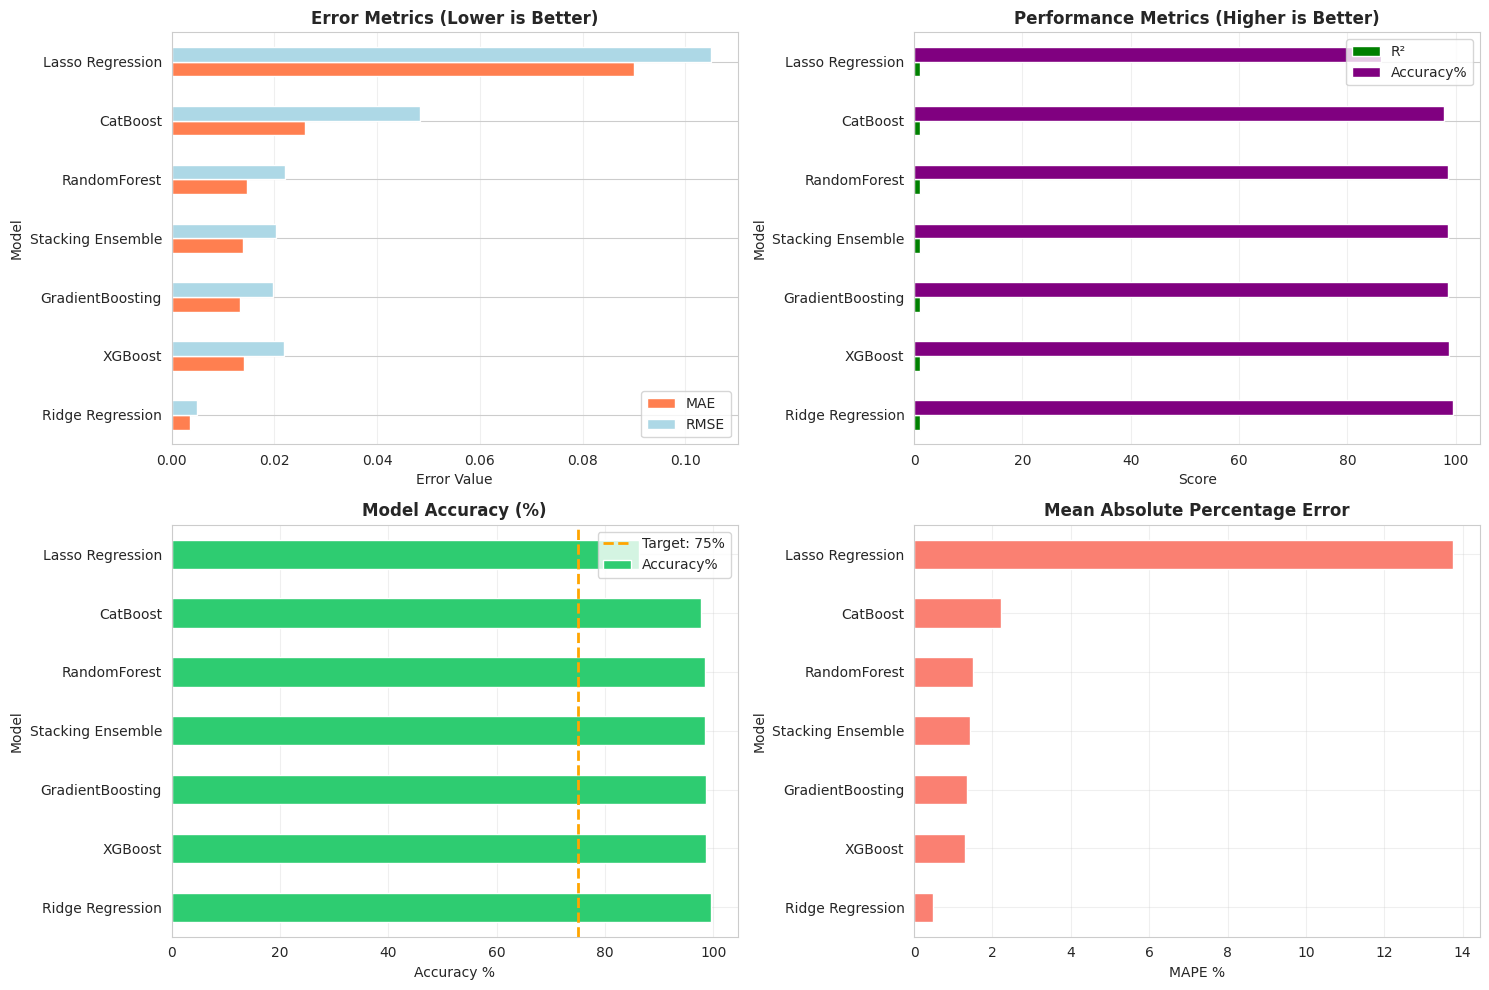

In [15]:
results_df = pd.DataFrame(results).sort_values('Accuracy%', ascending=False)
print("\n" + "="*70)
print("FINAL RESULTS (Sorted by Accuracy)")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

results_df.set_index('Model')[['MAE', 'RMSE']].plot(kind='barh', ax=axes[0, 0], color=['coral', 'lightblue'])
axes[0, 0].set_title("Error Metrics (Lower is Better)", fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel("Error Value")
axes[0, 0].grid(axis='x', alpha=0.3)

results_df.set_index('Model')[['R²', 'Accuracy%']].plot(kind='barh', ax=axes[0, 1], color=['green', 'purple'])
axes[0, 1].set_title("Performance Metrics (Higher is Better)", fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel("Score")
axes[0, 1].grid(axis='x', alpha=0.3)

colors = ['#2ecc71' if acc >= 75 else '#e74c3c' for acc in results_df['Accuracy%']]
results_df.plot(x='Model', y='Accuracy%', kind='barh', ax=axes[1, 0], color=colors, legend=False)
axes[1, 0].axvline(x=75, color='orange', linestyle='--', linewidth=2, label='Target: 75%')
axes[1, 0].set_title("Model Accuracy (%)", fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel("Accuracy %")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

results_df.plot(x='Model', y='MAPE%', kind='barh', ax=axes[1, 1], color='salmon', legend=False)
axes[1, 1].set_title("Mean Absolute Percentage Error", fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel("MAPE %")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Comparison

In [16]:
best_model_name = results_df.iloc[0]['Model']
best_model = trained_models[best_model_name]
best_accuracy = results_df.iloc[0]['Accuracy%']

print(f"\nBEST MODEL: {best_model_name}")
print(f"Accuracy: {best_accuracy:.2f}%")
print(f"R² Score: {results_df.iloc[0]['R²']:.4f}")

y_pred_best = best_model.predict(X_test_scaled)

# Create comprehensive comparison
print("\n" + "="*70)
print("ACTUAL vs PREDICTED COMPARISON")
print("="*70)

# Sample comparison table
comparison_df = pd.DataFrame({
    'DateTime': y_test.index,
    'Actual (kW)': y_test.values,
    'Predicted (kW)': y_pred_best,
    'Error (kW)': y_test.values - y_pred_best,
    'Absolute Error (kW)': np.abs(y_test.values - y_pred_best),
    'Error %': np.abs((y_test.values - y_pred_best) / y_test.values * 100)
})

print("\nPredictions (First 20):")
print(comparison_df.head(20).to_string(index=False))

print("\nPredictions (Last 20):")
print(comparison_df.tail(20).to_string(index=False))

print("\nError Statistics:")
print(f"Mean Absolute Error: {comparison_df['Absolute Error (kW)'].mean():.4f} kW")
print(f"Max Error: {comparison_df['Absolute Error (kW)'].max():.4f} kW")
print(f"Min Error: {comparison_df['Absolute Error (kW)'].min():.4f} kW")
print(f"Std Dev of Error: {comparison_df['Absolute Error (kW)'].std():.4f} kW")
print(f"Mean Error %: {comparison_df['Error %'].mean():.2f}%")

# Save detailed comparison
comparison_df.to_csv('actual_vs_predicted_comparison.csv', index=False)
print("\nSaved: actual_vs_predicted_comparison.csv")


BEST MODEL: Ridge Regression
Accuracy: 99.53%
R² Score: 1.0000

ACTUAL vs PREDICTED COMPARISON

Predictions (First 20):
           DateTime  Actual (kW)  Predicted (kW)  Error (kW)  Absolute Error (kW)  Error %
2007-03-24 18:00:00     3.023200        3.029423   -0.006223             0.006223 0.205828
2007-03-24 19:00:00     5.015867        5.026397   -0.010531             0.010531 0.209948
2007-03-24 20:00:00     3.887800        3.894679   -0.006879             0.006879 0.176948
2007-03-24 21:00:00     3.240300        3.245592   -0.005292             0.005292 0.163308
2007-03-24 22:00:00     4.117867        4.119299   -0.001432             0.001432 0.034772
2007-03-24 23:00:00     4.137300        4.135801    0.001499             0.001499 0.036237
2007-03-25 00:00:00     2.376533        2.369191    0.007342             0.007342 0.308934
2007-03-25 01:00:00     2.322633        2.310829    0.011805             0.011805 0.508240
2007-03-25 02:00:00     2.359733        2.347205    0.012528

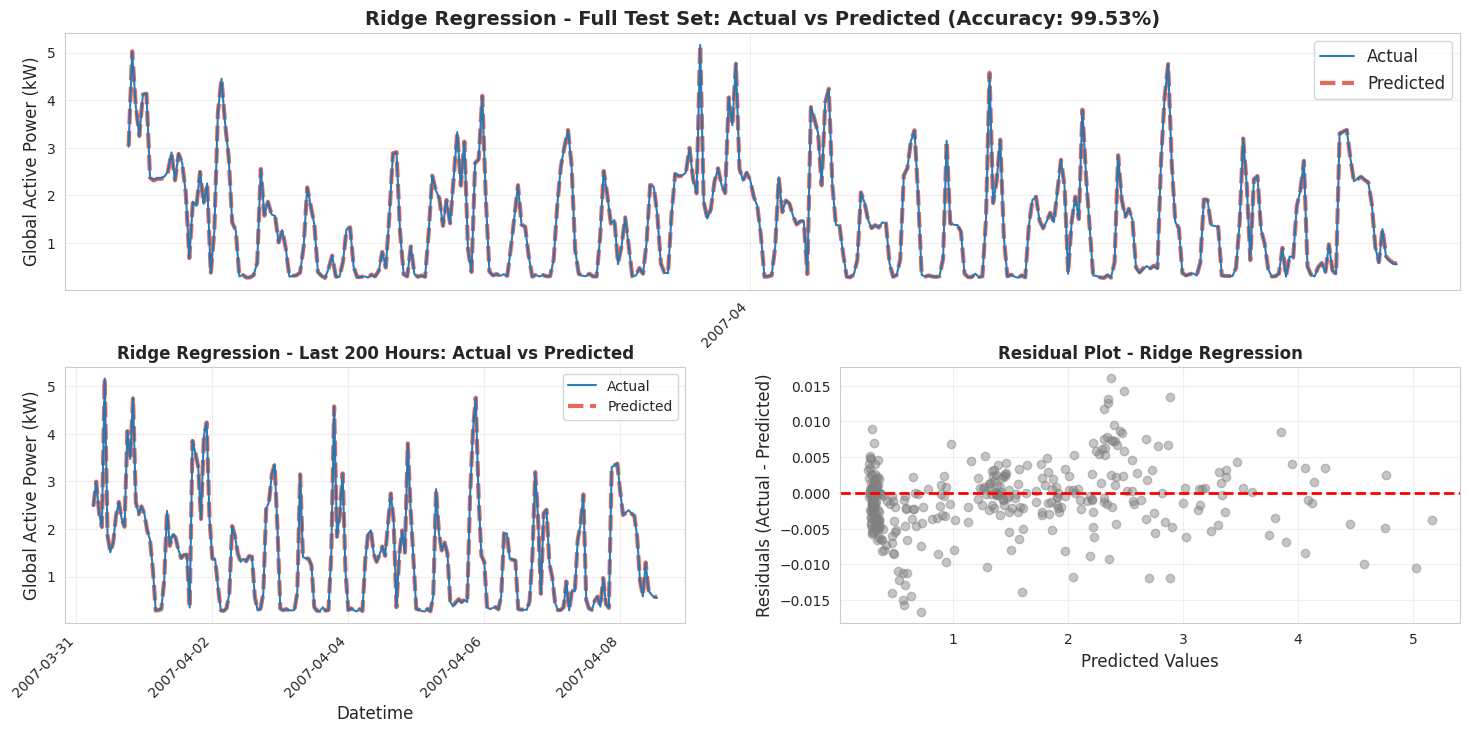

In [33]:
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 2, hspace=0.30, wspace=0.25)

ax1 = fig.add_subplot(gs[0, :])

# Actual
ax1.plot(
    y_test.index, y_test.values,
    label='Actual', color='#1f77b4',
    linewidth=1.5, alpha=0.95, zorder=3
)

# Predicted
ax1.plot(
    y_test.index, y_pred_best,
    label='Predicted', color='#e74c3c',
    linewidth=3.0, linestyle='--', alpha=0.85, zorder=2
)

ax1.set_title(
    f'{best_model_name} - Full Test Set: Actual vs Predicted (Accuracy: {best_accuracy:.2f}%)',
    fontsize=14, fontweight='bold'
)
ax1.set_ylabel('Global Active Power (kW)', fontsize=12)
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)


ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

ax2 = fig.add_subplot(gs[1, 0])
zoom_points = 200

ax2.plot(
    y_test.index[-zoom_points:], y_test.values[-zoom_points:],
    label='Actual', color='#1f77b4',
    linewidth=1.5, alpha=0.95, zorder=3
)

ax2.plot(
    y_test.index[-zoom_points:], y_pred_best[-zoom_points:],
    label='Predicted', color='#e74c3c',
    linewidth=3.0, linestyle='--', alpha=0.85, zorder=2
)

ax2.set_title(
    f'{best_model_name} - Last {zoom_points} Hours: Actual vs Predicted',
    fontsize=12, fontweight='bold'
)
ax2.set_xlabel('Datetime', fontsize=12)
ax2.set_ylabel('Global Active Power (kW)', fontsize=12)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

ax2.xaxis.set_major_locator(mdates.DayLocator(interval=2))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')


# RESIDUAL PLOT

ax3 = fig.add_subplot(gs[1, 1])
residuals = y_test.values - y_pred_best

ax3.scatter(y_pred_best, residuals, alpha=0.45, color='gray')
ax3.axhline(0, color='red', linestyle='--', linewidth=2)
ax3.set_title(f'Residual Plot - {best_model_name}', fontsize=12, fontweight='bold')
ax3.set_xlabel('Predicted Values', fontsize=12)
ax3.set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
ax3.grid(True, alpha=0.3)


plt.show()